<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/experiments/rooftops_segmentation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop segmentation (v3)
In this notebook we implement a deep learning model for the semantic segmentation task. We will use images of rooftops extracted from satellite images. The target of the model is to classify all the pixels in an image that belong to a rooftop. The model used for the segmentation task is based on the encoder-decoder architecture.

In [2]:
import os
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import numpy as np
from sklearn.metrics import jaccard_score
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print('Tensorflow version: {:s}'.format(tf.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 2.0.2
Tensorflow version: 2.18.0
Keras version. 3.8.0


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



## The dataset
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images. Train, validation, and test data are provided in separate zip files that contain a total of 305 RGB images and masks in binary digits, 0 and 1, as labels, in the PNG format. The size of the images is 250x250, that will be reduced to 224x224, and the resolution is 0.25x0.25 $m^2$

In [4]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_train.zip

epfl_buildings_trai 100%[===================>]  35.27M  --.-KB/s    in 0.08s   


In [5]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_test.zip

epfl_buildings_test 100%[===================>]   4.50M  --.-KB/s    in 0.02s   


In [11]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_val.zip

epfl_buildings_val. 100%[===================>]   4.32M  --.-KB/s    in 0.02s   


In [6]:
DATA_DIR = '.'
#DATA_DIR = '../data/epfl_buildings'

In [7]:
with ZipFile(f'{DATA_DIR}/epfl_buildings_train.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

In [8]:
with ZipFile(f'{DATA_DIR}/epfl_buildings_test.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

In [12]:
with ZipFile(f'{DATA_DIR}/epfl_buildings_val.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

The train, validation and test directories contain two subdirectories: images/ and labels/

In [13]:
p_train = Path(DATA_DIR + '/train/')
train_paths = []
[train_paths.append(sub_folder) for sub_folder in p_train.iterdir() if sub_folder.is_dir() and not sub_folder.name.startswith('.')]
train_images_path = train_paths[0]
train_labels_path = train_paths[1]

In [14]:
p_val = Path(DATA_DIR + '/val/')
val_paths = []
[val_paths.append(sub_folder) for sub_folder in p_val.iterdir() if sub_folder.is_dir() and not sub_folder.name.startswith('.')]
val_images_path = val_paths[0]
val_labels_path = val_paths[1]

In [15]:
p_test = Path(DATA_DIR + '/test/')
test_paths = []
[test_paths.append(sub_folder) for sub_folder in p_test.iterdir() if sub_folder.is_dir() and not sub_folder.name.startswith('.')]
test_images_path = test_paths[0]
test_labels_path = test_paths[1]

We create lists of the images and masks in each train, validation, and test set.

In [16]:
def create_file_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    file_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            file_list.append(os.path.join(raster_path, file))

    return sorted(file_list)

In [17]:
train_images_list = create_file_list(train_images_path)
print('Number of train images: {:d}'.format(len(train_images_list)))

Number of train images: 244


In [18]:
val_images_list = create_file_list(val_images_path)
print('Number of validation images: {:d}'.format(len(val_images_list)))

Number of validation images: 30


In [19]:
test_images_list = create_file_list(test_images_path)
print('Number of test images: {:d}'.format(len(test_images_list)))

Number of test images: 31


In [20]:
img_0 = io.imread(train_images_list[0])
print('Image shape: {}'.format(img_0.shape))

Image shape: (250, 250, 3)


We plot some images to have a look

In [21]:
def plot_images(images_list):
    fig_rows = 3
    fig_cols = 3
    fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
    index = 0
    for col in range(0, fig_cols):
        for row in range(0, fig_rows):
            img_natcol = io.imread(images_list[index])
            img_equalized = exposure.equalize_hist(img_natcol)
            ax[row, col].set_axis_off()
            ax[row, col].imshow(img_equalized)
            index += 1

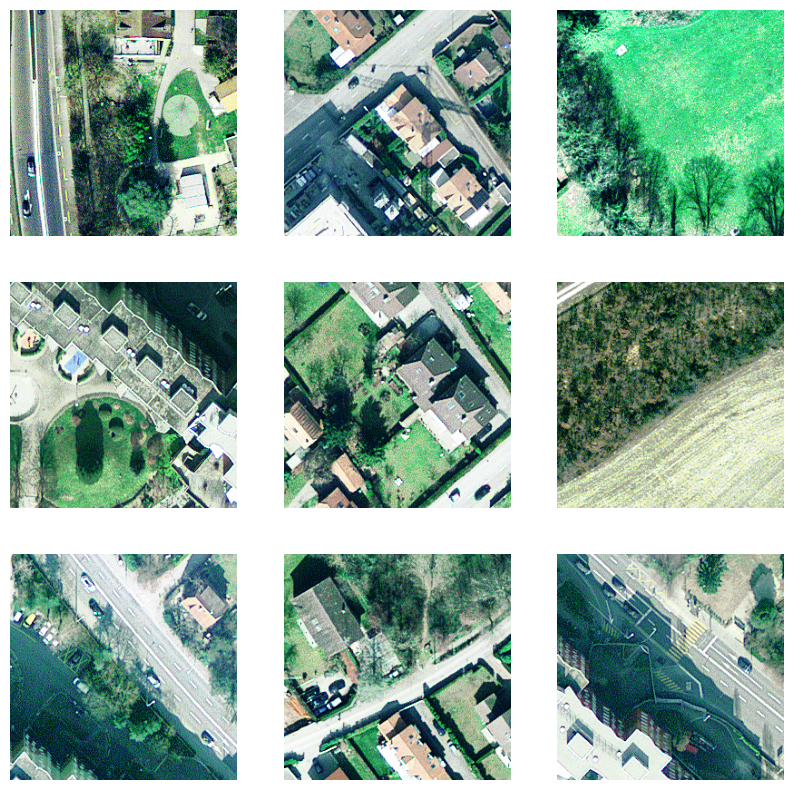

In [22]:
plot_images(train_images_list)

We create the list of the masks for training, validation and test as well

In [23]:
train_labels_list = create_file_list(train_labels_path)
val_labels_list = create_file_list(val_labels_path)
test_labels_list = create_file_list(test_labels_path)

In [24]:
label_0 = io.imread(train_labels_list[0])
print('Mask shape: {}'.format(label_0.shape))

Mask shape: (250, 250, 3)


The binary values used in the masks are 0 and 255

In [25]:
label_0_unique = np.unique(label_0)
print('Unique values in the mask: {}'.format(label_0_unique))


Unique values in the mask: [  0 255]


In [26]:
label_0_t = label_0.astype('uint8') - 255
np.unique(label_0_t)

array([0, 1], dtype=uint8)

We plot the masks of the images we saw before

In [27]:
def plot_masks(masks_list):
    fig_rows = 3
    fig_cols = 3
    fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
    index = 0
    for col in range(0, fig_cols):
        for row in range(0, fig_rows):
            mask = io.imread(masks_list[index])
            ax[row, col].set_axis_off()
            ax[row, col].imshow(mask)
            index += 1

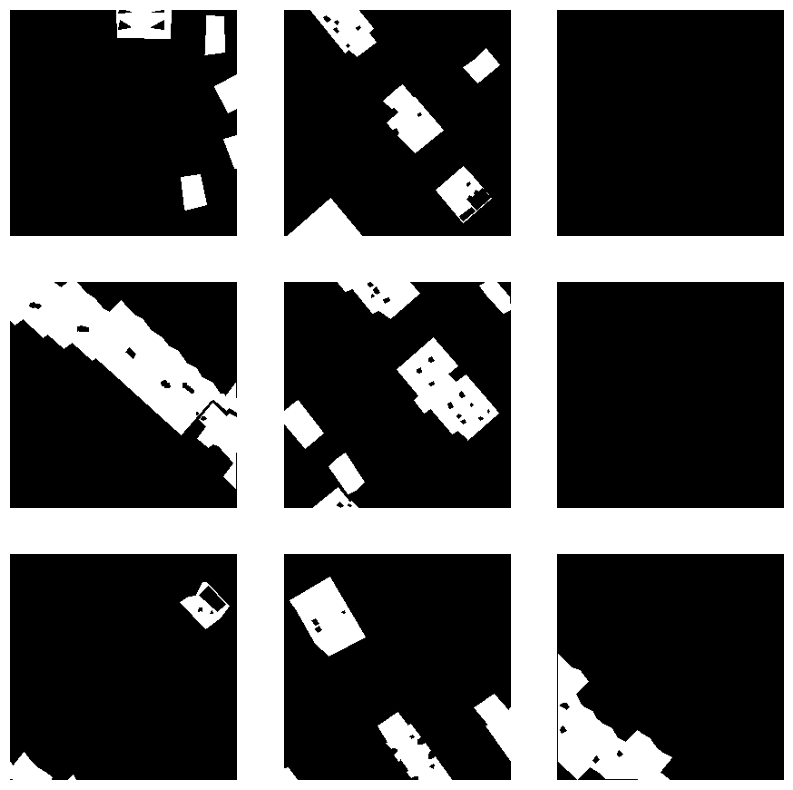

In [28]:
plot_masks(train_labels_list)

## Data preparation
We load the data into a Tensorflow Dataset for the training and validation. The images and masks must be resized from (250, 250) to (224, 224) and converted into tensors and put in batches.

In [29]:
import random
random.Random(1337).shuffle(train_images_list)
random.Random(1337).shuffle(train_labels_list)

In [30]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None):

    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf.io.read_file(input_img_path)
        input_img = tf.io.decode_png(input_img, channels=3) # transforms a png file into a tensor
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, "float16")  # was float32

        target_img = tf.io.read_file(target_img_path)
        target_img = tf.io.decode_png(target_img, channels=1)
        target_img = tf.image.resize(target_img, img_size, method="nearest") # Resize mask to match model output keeping the original Corine2018 values
        target_img = tf.image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3,.., 45. Subtract one to make them 0, 1, 2,..,44: Start with class index 0 otherwise the loss is not computed
        target_img -= 255
        return input_img, target_img

    def rotate90(img_tensor, msk_tensor):
        img_rotated = tf.image.rot90(img_tensor)
        msk_rotated = tf.image.rot90(msk_tensor)
        return img_rotated, msk_rotated

    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size)

In [31]:
batch_size = 4
img_size = (224, 224)

In [32]:
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_images_list,
    train_labels_list
)

In [33]:
print('Number of train batches: ', len(train_dataset))

Number of train batches:  61


In [34]:
for image_mask in train_dataset.take(1): # 1st tuple of the dataset containing a batch of images and a batch of masks
  image_batch = image_mask[0]
  mask_batch = image_mask[1]
  print('Batch image shape: {}\nBatch mask shape: {}'.format(image_batch.shape, mask_batch.shape))
  image = image_batch[1]
  mask = mask_batch[1]
  print('Image shape: {}\nMask shape: {}'.format(image.shape, mask.shape))
  print('Image min: {}, image max: {}'.format(image.numpy().min(), image.numpy().max()))
  print('Mask min: {}, mask max: {}'.format(mask.numpy().min(), mask.numpy().max()))
  print('Unique mask values: {}'.format(np.unique(mask)))

Batch image shape: (4, 224, 224, 3)
Batch mask shape: (4, 224, 224, 1)
Image shape: (224, 224, 3)
Mask shape: (224, 224, 1)
Image min: 5.8125, image max: 254.0
Mask min: 0, mask max: 1
Unique mask values: [0 1]


In [35]:
valid_dataset = get_dataset(batch_size, img_size, val_images_list, val_labels_list)

In [36]:
print('Number of validation batches: ', len(valid_dataset))

Number of validation batches:  8


In [37]:
for element in valid_dataset.take(1):
    print(element[0].shape) # Print shape of an image
    print(element[1].shape) # Print shape of a mask

(4, 224, 224, 3)
(4, 224, 224, 1)


In [38]:
test_dataset = get_dataset(batch_size, img_size, test_images_list, test_labels_list)

In [39]:
print('Number of test batches: ', len(test_dataset))

Number of test batches:  8


In [40]:
for element in test_dataset.take(1):
    print(element[0].shape) # Print shape of an image
    print(element[1].shape) # Print shape of a mask

(4, 224, 224, 3)
(4, 224, 224, 1)


In [41]:
def plot_tensor_in_dataset(ds, img_index=0):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    img_t = None
    msk_t = None
    for element in ds.take(1):
        img_t = element[0][img_index]
        msk_t = element[1][img_index]
        ax[0].axis("off")
        ax[1].axis("off")
        ax[0].imshow(array_to_img(img_t))
        ax[1].imshow(array_to_img(msk_t))

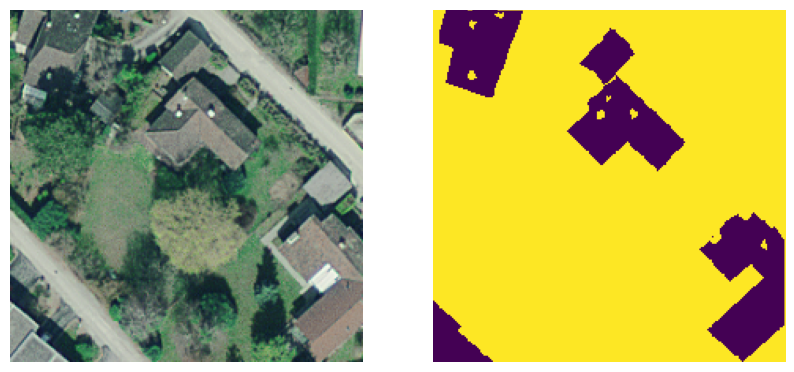

In [42]:
plot_tensor_in_dataset(train_dataset, img_index=1)

In [43]:
len(train_dataset)

61

### Data augmentation
Since the dataset is a small one we use data augmentation to increase the number of images for training. We define a layer to be used at the beginning of our model

In [44]:
def flip(img_tensor):
    img_flip = tf.image.flip_up_down(img_tensor)
    return img_flip

In [45]:
#def flip_img_msk(img_tensor, msk_tensor):
#    img_flip = tf.image.flip_up_down(img_tensor)
#    msk_flip = tf.image.flip_up_down(msk_tensor)
#    return img_flip, msk_flip

In [46]:
def rotate90(img_tensor):
        img_rotated = tf.image.rot90(img_tensor)
        return img_rotated

In [47]:
#def rotate90_img_msk(img_tensor, msk_tensor):
#        img_rotated = tf.image.rot90(img_tensor)
#        msk_rotated = tf.image.rot90(msk_tensor)
#        return img_rotated, msk_rotated

In [48]:
flip_train_dataset = train_dataset.map(lambda x, y: (flip(x), flip(y)), num_parallel_calls=tf.data.AUTOTUNE)

In [49]:
len(flip_train_dataset)

61

In [50]:
rotate_train_dataset = train_dataset.map(lambda x, y: (rotate90(x), rotate90(y)), num_parallel_calls=tf.data.AUTOTUNE)

In [51]:
len(rotate_train_dataset)

61

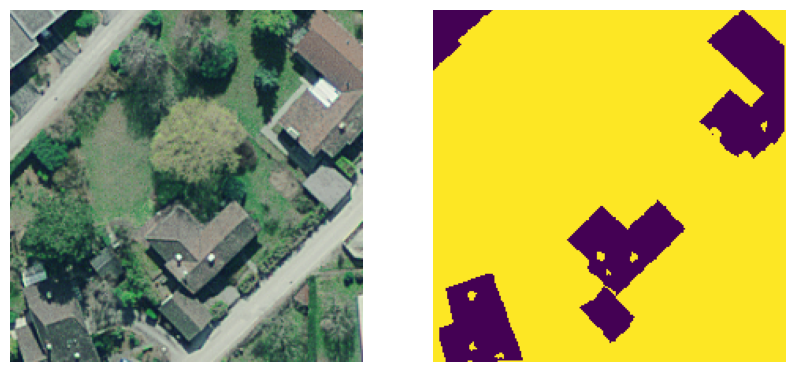

In [52]:
plot_tensor_in_dataset(flip_train_dataset, img_index=1)

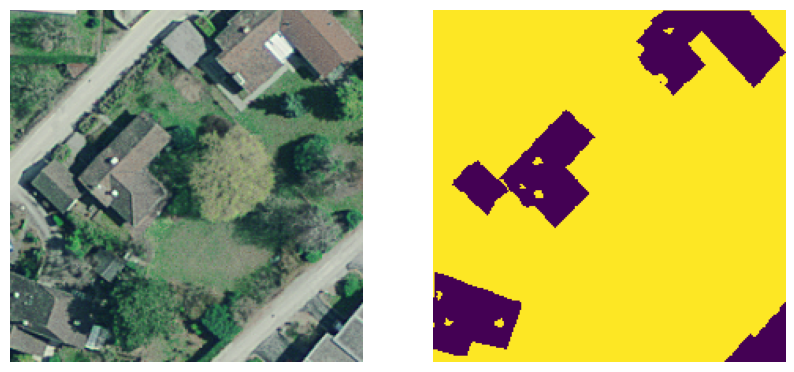

In [53]:
plot_tensor_in_dataset(rotate_train_dataset, img_index=1)

In [54]:
combined_rotate_flip_dataset = rotate_train_dataset.concatenate(flip_train_dataset)
len(combined_rotate_flip_dataset)

122

In [55]:
combined_train_dataset = train_dataset.concatenate(combined_rotate_flip_dataset)

In [56]:
len(combined_train_dataset)

183

## Building the encoder-decoder model
We use again the encoder-decoder model we used in a previous semantic segmentation task. The model includes the data augmentation step, three convolutional blocks for the downsamplig, and three transpose convolutional blocks for upsampling.

In [57]:
def build_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [58]:
model = build_model(img_size=img_size, num_classes=2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 112, 112,  │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 112, 112,  │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 56, 56,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 2,058,690 (7.85 MB)

 Trainable params: 2,054,914 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Model compilation
We use the [sparse categorical crossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as the loss function. it is a probabilistic loss function that expects integer values as label classes. During the training phase the labels are the masks that assign a class to each pixel in the input image. The predicted labels are computed pixel-wise by the softmax activation function. The sparse categorical crossentropy loss function computes difference between the pixels' label and the predicted ones.  

In [59]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy", #)
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("rooftop_segmentation.keras",
    save_best_only=True)
]

## Model training
We set the number of epochs, that is, the number of times we use the training set to update the model's weights, the batch size, that is, the number of (image, mask) pair to use before the model weights are updated.

In [60]:
history = model.fit(combined_train_dataset,
                    epochs=40,
                    callbacks=callbacks,
                    batch_size=4,
                    validation_data=valid_dataset)

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.8641 - loss: 0.5605 - val_accuracy: 0.8687 - val_loss: 1.1638
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9007 - loss: 0.2702 - val_accuracy: 0.8688 - val_loss: 1.5483
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9144 - loss: 0.2224 - val_accuracy: 0.8688 - val_loss: 1.3292
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9261 - loss: 0.1902 - val_accuracy: 0.8705 - val_loss: 0.6106
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9373 - loss: 0.1613 - val_accuracy: 0.8732 - val_loss: 0.5160
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9477 - loss: 0.1356 - val_accuracy: 0.8763 - val_loss: 0.4664
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9563 - loss: 0.1137 - val_accuracy: 0.8788 - val_loss: 0.4777
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9613 - loss: 0.1001 - val_ac

In [61]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

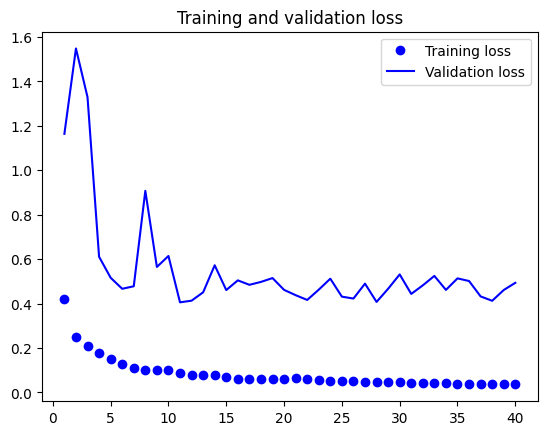

In [62]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

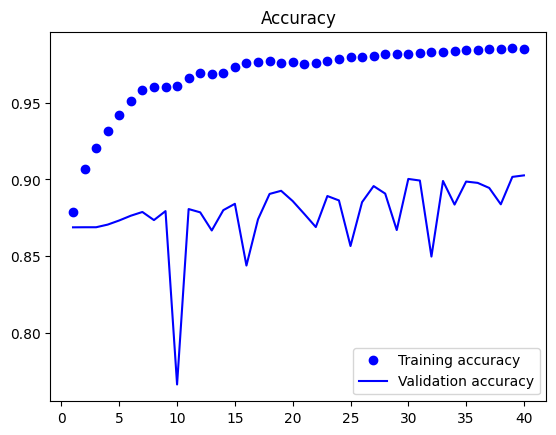

In [63]:
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Accuracy")
plt.legend(loc='lower right')

## Model predictions
We use the model with the lowest loss to predict the mask of an image that was not used for training. For each input image the model outputs a mask with two bands. One band contains the probability for a pixel to belong to the class 0, and the other band contains the probability for each pixel to belong to the class 1. Since in a binary classification the two probabilities are complementary we can use one of the two bands to plot the result. We set a threshold of 0.5 for a pixel probability to be in class 0 or 1.

In [64]:
best_model = keras.models.load_model("rooftop_segmentation.keras")

In [65]:
for batch in test_dataset.take(1):
  predicted_masks_batch = best_model.predict(batch[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
predicted_masks_batch[0].shape

(224, 224, 2)

In [66]:
def plot_predicted_mask(test_img, test_mask, predicted_mask):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
  predicted_mask_ch1 = np.expand_dims(predicted_mask, 2)

  ax[0].axis("off")
  ax[0].set_title('Test image')
  ax[0].imshow(array_to_img(test_img))
  ax[1].axis("off")
  ax[1].set_title('Test Mask')
  ax[1].imshow(array_to_img(test_mask))
  ax[2].axis("off")
  ax[2].set_title('Predicted Mask')
  ax[2].imshow(array_to_img(predicted_mask_ch1))


In [68]:
img_t = None
msk_t = None
i = 2
for element in test_dataset.take(1):
    img_t = element[0][i]
    print(img_t.shape)
    msk_t = element[1][i]
    print(msk_t.shape)

(224, 224, 3)
(224, 224, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


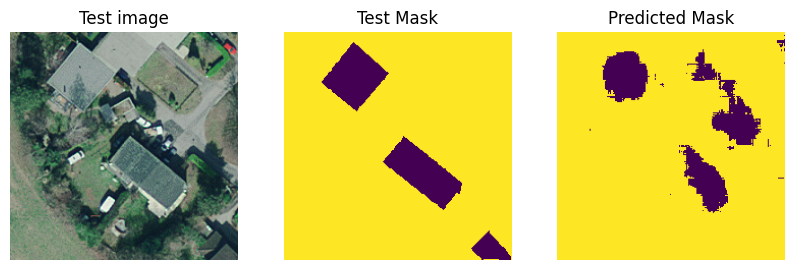

In [69]:
test_tensor = np.expand_dims(img_t, 0)
test_mask = np.expand_dims(msk_t, 0)
predicted_mask_tensor = best_model.predict(test_tensor)
predicted_mask = predicted_mask_tensor[0,:,:,1]
predicted_mask[predicted_mask >= 0.5] = 1
predicted_mask[predicted_mask < 0.5] = 0
predicted_mask = predicted_mask.astype(int)
plot_predicted_mask(img_t, msk_t, predicted_mask)

## Performance metric
We use *Intersection over Union*, (aka [Jaccard score](https://en.wikipedia.org/wiki/Jaccard_index)) as a metric for the model performance.

In [ ]:
predicted_mask.shape

(224, 224)

In [ ]:
predicted_mask_1d = predicted_mask.reshape(224*224)
predicted_mask_1d.shape

(50176,)

In [ ]:
label_0_unique = np.unique(predicted_mask)
print('Unique values in the mask: {}'.format(label_0_unique))

Unique values in the mask: [0 1]


In [ ]:
test_mask_2 = test_mask[:,:,0]
test_mask_2.shape

(224, 224)

In [ ]:
test_mask_1d = test_mask_2.reshape(224*224)
test_mask_1d.shape

(50176,)

In [ ]:
label_0_unique = np.unique(test_mask_2)
print('Unique values in the mask: {}'.format(label_0_unique))

Unique values in the mask: [0 1]


In [ ]:
iou = jaccard_score(test_mask_1d, predicted_mask_1d, average='binary', pos_label=1) * 100
print('Intersection over Union score: {:.2f}%'.format(iou))

Intersection over Union score: 90.25%


In [ ]:
product = test_mask_2 * predicted_mask
label_0_unique = np.unique(product)
print('Unique values in the mask: {}'.format(label_0_unique))

Unique values in the mask: [0 1]


In [ ]:
product.shape

(224, 224)

In [ ]:
y_true = np.array([[0, 0, 0],
                   [1, 1, 0],
                   [1, 1, 0]])

In [ ]:
y_true.shape

(3, 3)

In [ ]:
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0],
                   [1, 0, 0]])
y_pred.shape

(3, 3)

In [ ]:
y_true[1]

array([1, 1, 0])

In [ ]:
y_pred[1]

array([1, 0, 0])

In [ ]:
jaccard_score(y_true[1], y_pred[1])

np.float64(0.5)

In [ ]:
np.sum(y_pred[1] * y_true[1])

np.int64(1)

In [ ]:
def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
iou(test_mask_1d, predicted_mask_1d) * 100

np.float64(90.3)

In [ ]:
from google.colab import files
files.download('rooftop_segmentation.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>